In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, '/mnt/data/molchanov/dltranz')

from domyshnik.models import *
from domyshnik.data import *
from domyshnik.constants import *
from domyshnik.utils import *


def draw(imgs):
        if isinstance(imgs, list):
            imgs = torch.stack(imgs)
        fig = plt.figure()
        rows, columns = 1, imgs.shape[0]
        for i in range(imgs.shape[0]):
            fig.add_subplot(rows, columns, i+1)
            plt.imshow(imgs[i])
        plt.show()
        
%matplotlib inline

model _params:
        N_AUGMENTS 15
        LEARNING_RATE 0.002
        GAMMA 0.9025
        BATCH_SIZE 512
        EPOCHS 20
        SAMPLING_STRATEGY HardNegativePair
        NEGATIVES_COUNT 3
        MARGING 0.01
        STEP_SIZE 2
        MODEL_POSTFIX 
       
load model /mnt/data/molchanov/models/mnist_metric_learning.w
load model /mnt/data/molchanov/models/mnist_metric_learning.w


# Metric Learning MNIST Test 

In [ ]:
model = get_mnist_metriclearning_model()
model

In [ ]:
data_loader = get_mnist_test_loader(BATCH_SIZE, n_augments=N_AUGMENTS)
sample = next(iter(data_loader))
data = sample[0].view(-1, sample[0].size(-2), sample[0].size(-1))
draw(sample[0][0])

In [ ]:
embeds = model(sample[0])

In [ ]:
distances = torch.matmul(embeds, embeds.transpose(0, 1))
for i in range(distances.shape[0]):
    distances[i, i] = -100

In [ ]:
for i in range(distances.shape[0]):
    vals, idx = torch.sort(distances[i], descending=True)
    idx = [i] + idx[:N_AUGMENTS + 1].numpy().tolist()
    imgs = data[idx]
    draw(imgs)

# Domyshnik Mnist Test

In [11]:
import torch.nn.functional as F

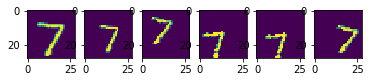

In [3]:
data_loader = get_mnist_test_loader(BATCH_SIZE, n_augments=5, augment_labels=True)
sample = next(iter(data_loader))
data = sample[0].view(-1, sample[0].size(-2), sample[0].size(-1))
draw(sample[0][0])

In [3]:
sample[1]

[tensor([1, 6, 1, 6, 0, 4, 9, 1, 0, 9, 2, 3, 6, 8, 9, 5, 1, 0, 4, 1, 4, 5, 8, 4,
         1, 5, 5, 1, 8, 0, 6, 9, 7, 6, 2, 4, 6, 9, 6, 0, 8, 1, 9, 4, 5, 5, 1, 2,
         8, 2, 2, 0, 6, 7, 6, 5, 2, 4, 1, 4, 9, 4, 2, 4, 3, 5, 9, 7, 2, 9, 7, 4,
         3, 4, 3, 0, 5, 8, 7, 6, 7, 0, 5, 5, 7, 8, 9, 8, 6, 4, 4, 3, 1, 6, 8, 0,
         2, 2, 9, 1, 8, 0, 7, 7, 0, 4, 4, 6, 0, 1, 5, 4, 8, 4, 1, 5, 1, 6, 8, 0,
         2, 8, 3, 4, 8, 5, 8, 5]),
 tensor([-0.1000, -0.1000, -1.0000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
         -0.1000, -1.0000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -1.0000,
         -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
         -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
         -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
         -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -1.0000, -1.0000, -1.0000,
         -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -1.0000, -0

# experiment 1 (domyshnik net)

In [2]:
info = mnist_domyshnik_lunch_info
sample = next(iter(info.test_loader))

In [4]:
model = get_mnist_domyshnik_model()
model

load model /mnt/data/molchanov/models/mnist_metric_learning.w
load model /mnt/data/molchanov/models/mnist_domushnik.w


MnistDomyshnikNetNet(
  (metric_learn_model): MnistMetricLearningNet2(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (dropout1): Dropout2d(p=0.25, inplace=False)
    (dropout2): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=9216, out_features=256, bias=True)
  )
  (fc0): Linear(in_features=256, out_features=512, bias=True)
  (fc1_): Linear(in_features=512, out_features=10, bias=True)
)

In [5]:
out = model(sample[0])
out = out.view(BATCH_SIZE, N_AUGMENTS + 1, out.size(-1))
out = F.softmax(out, dim=-1)
out.size()


torch.Size([512, 16, 10])

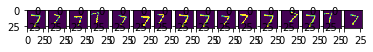

In [6]:
draw(sample[0][0])

In [7]:
out0 = out[0]
dists = torch.matmul(out0, out0.transpose(0, 1))
'max', dists.max(), 'min', dists.min()

('max',
 tensor(0.1643, grad_fn=<MaxBackward1>),
 'min',
 tensor(0.0932, grad_fn=<MinBackward1>))

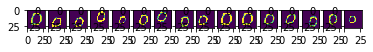

In [8]:
draw(sample[0][10])

In [9]:
out1 = out[1]
dists = torch.matmul(out0, out1.transpose(0, 1))
'max', dists.max(), 'min', dists.min()

('max',
 tensor(0.1221, grad_fn=<MaxBackward1>),
 'min',
 tensor(0.0806, grad_fn=<MinBackward1>))

In [10]:
print(out[0, 0])
print(out[0, 1])
print(out[0, 2])
print(out[0, 3])

print(out[10, 0])
print(out[110, 1])
print(out[23, 2])
print(out[4, 3])

tensor([0.2097, 0.0886, 0.0580, 0.0628, 0.1052, 0.1433, 0.1100, 0.1111, 0.0513,
        0.0600], grad_fn=<SelectBackward>)
tensor([0.2098, 0.1019, 0.0612, 0.0810, 0.0928, 0.1154, 0.1100, 0.0946, 0.0636,
        0.0696], grad_fn=<SelectBackward>)
tensor([0.1800, 0.0403, 0.0252, 0.0766, 0.1903, 0.1218, 0.1753, 0.0798, 0.0454,
        0.0655], grad_fn=<SelectBackward>)
tensor([0.0438, 0.1584, 0.0572, 0.1099, 0.0984, 0.1318, 0.1354, 0.1228, 0.0544,
        0.0879], grad_fn=<SelectBackward>)
tensor([0.1181, 0.0961, 0.0676, 0.0842, 0.0875, 0.1334, 0.1398, 0.0845, 0.0984,
        0.0904], grad_fn=<SelectBackward>)
tensor([0.0383, 0.1000, 0.0520, 0.2103, 0.0988, 0.1198, 0.1102, 0.1121, 0.0445,
        0.1139], grad_fn=<SelectBackward>)
tensor([0.0133, 0.1502, 0.0874, 0.0737, 0.1029, 0.1116, 0.1126, 0.0957, 0.1584,
        0.0942], grad_fn=<SelectBackward>)
tensor([0.0799, 0.0316, 0.0313, 0.0100, 0.2652, 0.1547, 0.0171, 0.0865, 0.1637,
        0.1600], grad_fn=<SelectBackward>)


# experiment 2 metric learning simularity

In [8]:
m_model = get_mnist_metriclearning_model()
m_model

load model /mnt/data/molchanov/models/mnist_metric_learning.w


MnistMetricLearningNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (norm): L2Normalization()
)

In [9]:
m_out = m_model(sample[0])
m_out = m_out.view(BATCH_SIZE, N_AUGMENTS + 1, m_out.size(-1))
m_out.size()

torch.Size([512, 26, 32])

In [25]:
m_out0 = m_out[0]
dists = torch.matmul(m_out0, m_out0.transpose(0, 1))
'max', dists.max(), 'min', dists.min()

('max',
 tensor(1.0000, grad_fn=<MaxBackward1>),
 'min',
 tensor(0.9851, grad_fn=<MinBackward1>))

In [31]:
m_out1 = m_out[130]
dists = torch.matmul(m_out0, m_out1.transpose(0, 1))
'max', dists.max(), 'min', dists.min()

('max',
 tensor(0.9847, grad_fn=<MaxBackward1>),
 'min',
 tensor(0.8532, grad_fn=<MinBackward1>))

In [33]:
dists = F.pairwise_distance(m_out0, m_out[10])
'max', dists.max(), 'min', dists.min()

('max',
 tensor(0.4538, grad_fn=<MaxBackward1>),
 'min',
 tensor(0.2940, grad_fn=<MinBackward1>))

In [39]:
t = -1
for i in range(BATCH_SIZE):
    dists = F.pairwise_distance(m_out[i], m_out[i][torch.randperm(m_out0.size(0))])
    if t < dists.max().item():
        t = dists.max().item()
'max', t

('max', 0.504342257976532)

In [40]:
t = -1
for i in range(BATCH_SIZE):
    dists = F.pairwise_distance(m_out[0], m_out[i])
    if t < dists.max().item():
        t = dists.max().item()
'max', t

('max', 0.5334939360618591)